## Maximum likelihood model fitting

In [1]:
import numpy as np
import scipy as sp
import scipy.io as sio
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import importlib

In [2]:
file_name = 'BH04_raw_acquisition.xlsx'
dataset = pd.read_excel(file_name)
# dataset

In [3]:
dataset.drop(dataset[dataset['Chosen']==0].index, inplace = True) ## removed all rows where 'Chosen' == 0 is true 
# dataset
# 'Chosen == 0' on a premature response or an omission

configA = np.array([1, 4, 0, 2, 3])
configB = np.array([4, 1, 0, 3, 2])

dataset['MSN'].unique() ## the 2 versions of the task

dataset['option'] = dataset['MSN'].str.contains("B").values*configB[dataset['Chosen'].astype('int').ravel()-1].astype('int') + \
    dataset['MSN'].str.contains("A").values*configA[dataset['Chosen'].astype('int').ravel()-1].astype('int') 
## makes a new column called 'option' which stores P1-P4 choice depending on 'Chosen' and version of the task 

dataset[dataset['Subject'] == 2][['Pun_Dur','Pellets','Chosen','option']]
## dataset where subject == 1 (1149 rows), and only shows 4 columns + 'Chosen' != 0 

,Pun_Dur,Pellets,Chosen,option
1970,0,1,2,1
1971,0,1,2,1
1973,0,1,2,1
1974,0,2,5,2
1975,0,2,5,2
...,...,...,...,...
51713,0,2,5,2
51715,0,2,5,2
51716,0,2,5,2
51717,0,2,5,2


In [4]:
from scipy.optimize import minimize
from scipy.special import logsumexp

def mylikelihood(params, ch, rew, pun, ntrials):

    # params is a 3 vector of beta, etaP, etaN
    # ch is a vector of choices (one per trial) (P1-P4 choice)
    # rew is a vector of rewards (Pellets)
    # pun is a vector of punishments (Pun_Dur)
    
    V = np.zeros(4) ## V = latent Q values which start at 0 
    ## V stores Q value of P1, Q(P2), Q(P3), Q(P4)
    beta = params[0] ## takes the first number in the params vector 
    etaP = params[1]
    etaN = params[2]

    loglik = 0 ## start at 0
    
    for t in range(ntrials): 
    
        # now we want to calculate the log likelihood of the choice on the current trial
        ## ln(e) = 1
        ## log likelihood is ln(p(P#))*** for each choice - and is the sum of each trial 
        ## each trial, we update loglik (adding to it) depending on the P1-P4 choice
        ## simultaneously, we update the respective Q value for a certain choice depending on the outcome (win or lose) 
        ## p(Px) "probability of the data given the parameters we pass to the function (beta, etaN, etaP)"
        # we assume the prob of each choice follows a softmax rule
        ## the log likelihood is the joint probability of the data (vector of choices, summed because we're logging) given the model and the parameters of the model
        # in log this looks like this
        
        loglik += beta*V[ch[t]-1] - logsumexp(beta*V) 
        ## ln likelihood is equal to ln(softmax rule)  
        ## recall: the log likelihood is just the likelihood (parameters given data) with log***
        ## += just adds to current value 
        ## this depends on their P1-P4 choice V[ch[t] - 1]
        ## the following if code depends on the outcome (win or lose) 
        
        if rew[t]>0:
            V[ch[t]-1] += etaP*(rew[t] - V[ch[t]-1])
            # this is the same as writing
            # V[chosen option](new) = V[chosen option](old)* + etaP*(reward - V[chosen option](old))
            ## Note that V[chosen option](old)* isn't present in the equation due to the += 
        else: ## when rew[t] == 0
            V[ch[t]-1] += etaN*(-pun[t] - V[ch[t]-1])
            ## V[chosen option] = V[chosen option] + etaN*(punishment - V[chosen option])
            ## decreases the Q value (V)
            ## punishment is experienced time-out duration in seconds (assumes m is 1 in this example)

    return -loglik #easier to minimize than maximize 

##function: note how loglik is accumulating in magnitude with each trial, and how only one V updates per trial 
##what does the loglik value represent?*** why do we want to minimize/maximize it?*** ### answered above 

## Test boxes

In [ ]:
t = range(ntrials)
# t
choices[t]-1 ## holds an array of (P1-P4 choice - 1) for each trial (ex. P1 - 1 = 0 in the array)
V = np.zeros(4) 
# V
V[choices[t]-1] ## irrelevant storage --> function:
## V[0] stores Q(P1), therefore, we must subtract 1 from choices[t] in order to update the correct value in V

beta = 10

V_test = np.array([1,1,1,1])
V_test

logsumexp(beta*V_test)

In [ ]:
a = np.arange(10)
np.log(np.sum(np.exp(a)))
a

np.exp(a) ## e^x
np.sum(a)
np.sum(np.exp(a))
# np.log(a) #ln, not log 
np.log(np.sum(np.exp(a)))
logsumexp(a) ## same value as above

## MLE code again

In [5]:
# pull out the information we need for MLE

#this is for subject 2 only

# .values squashes the pandas Series back to a numpy array
## pandas Series is a one column dataframe 
## numpy array is different - can iterate through 
choices = dataset.loc[dataset['Subject']==2,'option'].values 
## for subject 2, outputs an array of P1-P4 choice (stored in 'option' column) for each trial 
## recall: 'Chosen' == 0 was removed 

rewards = dataset.loc[dataset['Subject']==2,'Pellets'].values 
## outputs number of pellets rewarded per trial ('Chosen != 0') --> 0 means they lost 

punishments = dataset.loc[dataset['Subject']==2,'Pun_Dur'].values
## outputs punishment durations --> 0 means they won, and ex) 40 means they wait for 40sec

ntrials = len(punishments)
## punishments was arbitrary --> ntrials stores the number of trials for this subject (can we assume each subject only played one version - MSN? 
# --> yes must check)

# now I can test the likelihood with some fixed parameter values...
test_parameters = [10,0.5,0.5] ## random values 
mylikelihood(test_parameters, choices, rewards, punishments, ntrials)

# now we know our function works!!!

#this prints out the negative log likelihood, which is the number we want to minimize 

28855.6971560019

## Test Box

In [ ]:
# choices = dataset.loc[dataset['Subject']==2,'option'].values
# choices

## MLE Code

In [6]:
# now we can ask the optimizer to find the parameter values that minimize the negative log likelihood calculated by our function!

## test_parameters are an educated initialization
## args = additional arguments 
## bounds are respective to beta, etaP, etaN
# len(punishments)

results = minimize(mylikelihood,test_parameters,args=(choices,rewards,punishments,ntrials),bounds=((0, None), (0, 1), (0, 1)))
results
## minimize --> a function that finds the parameter values that minimize the negative log-likelihood calculated by our function

      fun: 541.6397693014861
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00017053, -0.00017053,  0.00267164])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 19
     njev: 21
   status: 0
  success: True
        x: array([2.96881148, 0.07157529, 0.00535836])

In [7]:
# usually, you will iterate over 3-5 minimize calls, with different random starting points, and choose the one with the 
# highest (ie, lowest negative) likelihood (lowest -loglik)

## highest loglik (least negative, closest to 0) is at the combination of parameters that best fit the data (the ML parameter estimates) 
## lowest -loglik is the same thing!^ ***
## the combination of parameters that best fit the data (variable) will minimize -loglik - recall: L(theta | y) 
## we pass random initiatlizations to each parameter value

init = 3 # three different initializations

estimates = np.zeros([init,4]) ## stores array of zeros, 3 rows of 4 zeros each 

for n in range(init): ## range 0-3
    print(n)
    
    res = minimize(mylikelihood,[10+np.random.rand()*10,0.5+np.random.rand()*0.2,0.5+np.random.rand()*0.2],
                   args=(choices,rewards,punishments,ntrials),bounds=((0, None), (0, 1), (0, 1))) 
    ## res is the minimize function, with the addition of random numbers to beta, etaP and etaN 

    print(res.fun, res.x[0], res.x[1], res.x[2])
    estimates[n,:] = [res.fun, res.x[0], res.x[1], res.x[2]]


#for the print out - 1st value is the minimized negative log likelihood
#second value is the beta parameter
#third value is the etaP parameter
#fourth value is the etaN parameter

## res.fun calls the 'fun' field in res 
## 0 1 2 represent the 1st, 2nd and 3rd initialization

0
541.6397693017077 2.9688093520914305 0.07157527370521578 0.005358344008024617
1
541.6397693015044 2.96881096700948 0.07157532767872697 0.005358353540880911
2
541.6397693016222 2.968810544484767 0.07157529546885705 0.005358342216925646


## Test box

In [ ]:
estimates_test = np.zeros((3,4)) 
estimates_test
range(init) 
np.random.rand()

np.linspace(0, 5, 11)
np.linspace(0.005,0.1,21)

np.zeros([len(beta), len(etaP)]) ## 11 rows of 21 zeros each

## MLE Code

In [8]:
# it is useful to plot the entire likelihood surface for your data given the model

beta = np.linspace(0,5,11) ##between 0 and 5, gives 11 evenly spaced out values from 0 to 5
etaP = np.linspace(0.005,0.1,21) 
etaN = 0.00536

nll = np.zeros([len(beta),len(etaP)])

for b in range(len(beta)):
    for e in range(len(etaP)):
        
        nll[b,e] = mylikelihood([beta[b],etaP[e],etaN],choices,rewards,punishments,ntrials)
        
        ## for beta = 0, etaP = 0.005 --> -loglik = 2449.58
        ## for beta = 0, etaP = 0.00975 --> -loglik = 2449.58 
        ## function: for each b, test the 21 etaP values, output the -loglik (from mylikelihood)
        ## output: 11*21 -loglik values 

In [9]:
#nll stores the likelihoods for each of the parameter values stored in beta and etaP 
nll

array([[2449.5821361 , 2449.5821361 , 2449.5821361 , 2449.5821361 ,
        2449.5821361 , 2449.5821361 , 2449.5821361 , 2449.5821361 ,
        2449.5821361 , 2449.5821361 , 2449.5821361 , 2449.5821361 ,
        2449.5821361 , 2449.5821361 , 2449.5821361 , 2449.5821361 ,
        2449.5821361 , 2449.5821361 , 2449.5821361 , 2449.5821361 ,
        2449.5821361 ],
       [2549.26190037, 2031.21467986, 1845.78857026, 1755.74097039,
        1704.59900756, 1672.80093978, 1651.96089041, 1637.93825399,
        1628.46526124, 1622.1956233 , 1618.2768792 , 1616.14036945,
        1615.39035368, 1615.74177522, 1616.98343454, 1618.95517248,
        1621.53315647, 1624.6200571 , 1628.13829005, 1632.02524536,
        1636.22984385],
       [2698.87568456, 1712.43905867, 1411.49324333, 1278.85488325,
        1207.57038216, 1164.50295735, 1136.58011908, 1117.74785293,
        1104.85263611, 1096.09363757, 1090.36348467, 1086.93912166,
        1085.32497709, 1085.16788061, 1086.20812094, 1088.24980437,


[[<matplotlib.axis.XTick at 0x1af7b99af70>,
 [Text(0, 0, '0'), Text(20, 0, '0.1')],
 [Text(0, 0, '0'), Text(0, 10, '5')]]

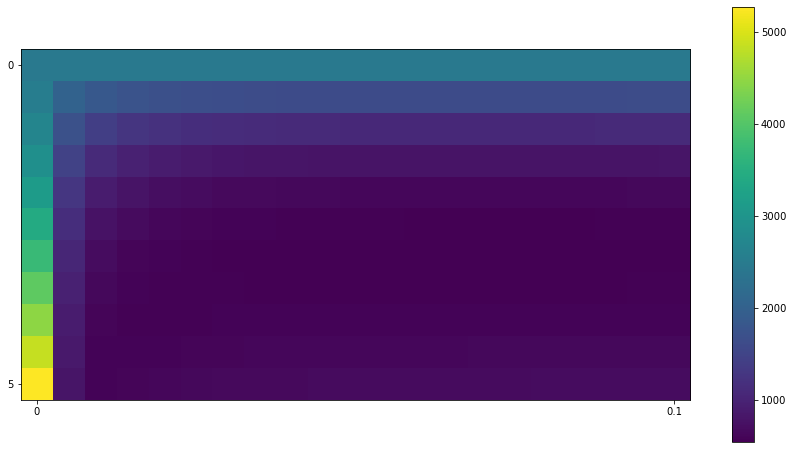

In [11]:
#this plots the likelihood surface --> best parameter fits are at the darkest colour (minimum negative LL)

#from the MLE function a few cells above, we know the best fits are at beta = 2.97, and etaP = .07

fig,ax = plt.subplots(1,1,figsize=[15,8])

im = ax.imshow(nll)
fig.colorbar(im,ax=ax)
ax.set(xticks=[0,20],xticklabels=[0,.1],yticks=[0,10],yticklabels=[0,5])

## likelihood surface 
## slice of likelihood surface at etaN = 0.00536
## y axis is beta, x-axis is etaP 
## axis towards me is -loglik

In [10]:
# subjects
# estimates
# range(len(subjects)) ## issue: there is no subject 0 

# now we can do this over all subjects

init = 3
subjects = dataset['Subject'].unique()
estimates = np.zeros([len(subjects),init,4])
for sub in range(len(subjects)):
    print(f'Subject {subjects[sub]}...')
    
    choices = dataset.loc[dataset['Subject']==subjects[sub],'option'].values

    rewards = dataset.loc[dataset['Subject']==subjects[sub],'Pellets'].values

    punishments = dataset.loc[dataset['Subject']==subjects[sub],'Pun_Dur'].values
    
    ntrials = len(punishments)
    
    for n in range(init):
        print(n)
        res_test = minimize(mylikelihood,[10+np.random.rand()*10,0.5+np.random.rand()*0.2,0.5+np.random.rand()*0.2],
                       args=(choices,rewards,punishments,ntrials),bounds=((0, None), (0, 1), (0, 1)))
    
        print(res.fun, res.x[0], res.x[1], res.x[2])
        estimates[sub,n,:] = [res.fun, res.x[0], res.x[1], res.x[2]]

541.6397693016222 2.968810544484767 0.07157529546885705 0.005358342216925646
1
541.6397693016222 2.968810544484767 0.07157529546885705 0.005358342216925646
2


KeyboardInterrupt: 